In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import torchvision.models as models
from torchvision import transforms
import random
import cv2
import time
import matplotlib.pyplot as plt

In [3]:
class Discriminator(nn.Module):
    def __init__(self, max_iter, num_domains):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, num_domains)
        self.ad_net = nn.Sequential(
            self.fc1,
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            self.fc2
        )
        self.grl_layer = GRL(max_iter)

    def forward(self, feature):
        adversarial_out = self.ad_net(self.grl_layer(feature))
        return adversarial_out

class SSAN_R(nn.Module):
    def __init__(self, ada_num=2, max_iter=4000, num_domains=1):
        super(SSAN_R, self).__init__()
        model_resnet = models.resnet18(pretrained=True)

        self.input_layer = nn.Sequential(
            model_resnet.conv1,
            model_resnet.bn1,
            model_resnet.relu,
            model_resnet.maxpool
        )
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.adaIN_layers = nn.ModuleList([ResnetAdaINBlock(256) for i in range(ada_num)])

        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        self.cls_head = nn.Linear(512, 2, bias=True)

        self.gamma = nn.Linear(256, 256, bias=False)
        self.beta = nn.Linear(256, 256, bias=False)

        self.FC = nn.Sequential(
            nn.Linear(256, 256, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ada_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.ada_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.ada_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256)
        )
        self.dis = Discriminator(max_iter, num_domains)

    def cal_gamma_beta(self, x1):
        x1 = self.input_layer(x1)
        x1_1 = self.layer1(x1)
        x1_2 = self.layer2(x1_1)
        x1_3 = self.layer3(x1_2)

        x1_4 = self.layer4(x1_3) # content feature
        
        x1_add = x1_1
        x1_add = self.ada_conv1(x1_add)+x1_2
        x1_add = self.ada_conv2(x1_add)+x1_3
        x1_add = self.ada_conv3(x1_add) # style feature tổng hợp

        gmp = torch.nn.functional.adaptive_max_pool2d(x1_add, 1)
        gmp_ = self.FC(gmp.view(gmp.shape[0], -1))
        gamma, beta = self.gamma(gmp_), self.beta(gmp_) # gamma, beta từ style feature

        domain_invariant = torch.nn.functional.adaptive_avg_pool2d(x1_4, 1).reshape(x1_4.shape[0], -1) #embedding dùng trong L_adv

        return x1_4, gamma, beta, domain_invariant

    def forward(self, input1, input2):
        x1, gamma1, beta1, domain_invariant = self.cal_gamma_beta(input1)
        x2, gamma2, beta2, _ = self.cal_gamma_beta(input2)

        # Self-assembly S(xi, xi)
        fea_x1_x1 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x1 = self.adaIN_layers[i](fea_x1_x1, gamma1, beta1)
        fea_x1_x1 = self.conv_final(fea_x1_x1)
        fea_x1_x1 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x1, 1)
        fea_x1_x1 = fea_x1_x1.reshape(fea_x1_x1.shape[0], -1)
        cls_x1_x1 = self.cls_head(fea_x1_x1)

        # Shuffle-assembly S(xi, xi*)
        fea_x1_x2 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x2 = self.adaIN_layers[i](fea_x1_x2, gamma2, beta2)
        fea_x1_x2 = self.conv_final(fea_x1_x2)
        fea_x1_x2 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x2, 1)
        fea_x1_x2 = fea_x1_x2.reshape(fea_x1_x2.shape[0], -1)

        dis_invariant = self.dis(domain_invariant)
        return cls_x1_x1, fea_x1_x1, fea_x1_x2, dis_invariant

In [4]:
class GRL(nn.Module):
    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff * gradOutput


class adaIN(nn.Module):

    def __init__(self, eps=1e-5):
        super(adaIN, self).__init__()
        self.eps = eps

    def forward(self, input, gamma, beta):
        in_mean, in_var = torch.mean(input, dim=[2, 3], keepdim=True), torch.var(input, dim=[2, 3], keepdim=True)
        out_in = (input - in_mean) / torch.sqrt(in_var + self.eps)
        out = out_in
        out = out * gamma.unsqueeze(2).unsqueeze(3) + beta.unsqueeze(2).unsqueeze(3)
        return out

class ResnetAdaINBlock(nn.Module):

    def __init__(self, dim):
        super(ResnetAdaINBlock, self).__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = adaIN()
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = adaIN()

    def forward(self, x, gamma, beta):
        out = self.conv1(x)
        out = self.norm1(out, gamma, beta)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return out+x

In [5]:
# Cấu hình 

from types import SimpleNamespace

cfg = SimpleNamespace()

# Đường dẫn dữ liệu của bạn
cfg.data_dir      = "./dataset_processed"  # chỉnh nếu khác
cfg.result_path   = "./results"            # nơi lưu model, score, csv
cfg.result_name   = "ssan_custom"          # tên run

# Training settings
cfg.model_type    = "SSAN_R"   # hiện tại chỉ dùng SSAN_R (binary)

cfg.batch_size    = 32 
cfg.img_size      = 256
cfg.map_size      = 32
cfg.num_epochs    = 80   # Với early stop patience = 20
cfg.start_epoch   = 0         
cfg.print_freq    = 10

# Optimizer & scheduler
cfg.base_lr       = 5e-5
cfg.momentum      = 0.9
cfg.weight_decay  = 1e-4
cfg.step_size     = 15
cfg.gamma         = 0.5

# Augmentation mode: "o" (original), "p" (pure), "I" (ImageNet)
cfg.trans         = "o"      # Full augmentation - TỐT cho 40K images

cfg.debug_subset_size = None # None = dùng toàn bộ dataset

# Domain
DOMAIN_NAME_TO_ID = {
    "CUSTOM": 0,
    "CUSTOM2": 1,
    "MSU_MFSD": 2,
    "SiW": 3,
    "WEBCAM": 4,
}
cfg.num_domains = len(DOMAIN_NAME_TO_ID)

# ===== EARLY STOPPING cho Kaggle (12h limit) =====
cfg.early_stop_patience = 20       # Giữ 20 epochs (đủ cho dataset lớn)
cfg.monitor_metric = "auc-hter"    # Monitor AUC - HTER (robust)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# Transforms cho training / testing

class Normaliztion(object):
    """
    Chuẩn hóa ảnh về [-1, 1]: image = (image - 127.5) / 128
    Đồng thời map_x về [0,1]
    """
    def __call__(self, sample):
        image_x = sample['image_x']
        map_x   = sample['map_x']
        image_x = (image_x - 127.5) / 128.0
        sample['image_x'] = image_x
        sample['map_x']   = map_x / 255.0
        return sample


class Normaliztion_ImageNet(object):
    # Chuẩn hóa theo mean/std ImageNet
    def __init__(self):
        self.trans = transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, sample):
        image_x = sample['image_x'] / 255.0
        image_x = self.trans(image_x)
        sample['image_x'] = image_x
        map_x = sample['map_x']
        sample['map_x'] = map_x / 255.0
        return sample


class ToTensor(object):
    # Convert numpy image HxWxC (BGR/RGB) -> torch Tensor CxHxW
    def __call__(self, sample):
        image_x, map_x, spoofing_label = sample['image_x'], sample['map_x'], sample['label']
        # Chuyển từ HxWxC (BGR) sang CxHxW (RGB)
        image_x = image_x[:, :, ::-1].transpose((2, 0, 1))  # BGR -> RGB, HWC -> CHW
        image_x = np.array(image_x)
        map_x   = np.array(map_x)

        spoofing_label_np = np.array([0], dtype=np.longlong)
        spoofing_label_np[0] = spoofing_label

        sample['image_x'] = torch.from_numpy(image_x.astype(np.float32)).float()
        sample['map_x']   = torch.from_numpy(map_x.astype(np.float32)).float()
        sample['label']   = torch.from_numpy(spoofing_label_np).long()
        return sample


class Cutout(object):
    def __init__(self, length=50):
        self.length = length

    def __call__(self, sample):
        img = sample['image_x']
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        length_new = np.random.randint(1, self.length)
        y1 = np.clip(y - length_new // 2, 0, h)
        y2 = np.clip(y + length_new // 2, 0, h)
        x1 = np.clip(x - length_new // 2, 0, w)
        x2 = np.clip(x + length_new // 2, 0, w)
        mask[y1:y2, x1:x2] = 0.0
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        img *= mask
        sample['image_x'] = img
        return sample


class RandomHorizontalFlip(object):
    def __call__(self, sample):
        if random.random() < 0.5:
            image_x = sample["image_x"]
            map_x   = sample["map_x"]
            image_x = cv2.flip(image_x, 1)
            map_x   = cv2.flip(map_x, 1)
            sample["image_x"] = image_x
            sample["map_x"]   = map_x
        return sample


class Contrast_and_Brightness(object):
    def __call__(self, sample):
        image_x = sample["image_x"]
        # Tăng range để robust hơn với webcam
        gamma = random.randint(-50, 50)  # Thay vì -40, 40
        alpha = random.uniform(0.4, 1.6)  # Thay vì 0.5, 1.5
        image_x = cv2.addWeighted(image_x, alpha, image_x, 0, gamma)
        sample["image_x"] = image_x
        return sample


class RandomRotation(object):
    """Thêm rotation nhỏ để robust với góc nghiêng"""
    def __init__(self, max_angle=10):
        self.max_angle = max_angle
    
    def __call__(self, sample):
        if random.random() < 0.5:
            image_x = sample["image_x"]
            map_x = sample["map_x"]
            
            angle = random.uniform(-self.max_angle, self.max_angle)
            h, w = image_x.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            
            image_x = cv2.warpAffine(image_x, M, (w, h))
            map_x = cv2.warpAffine(map_x, M, (map_x.shape[1], map_x.shape[0]))
            
            sample["image_x"] = image_x
            sample["map_x"] = map_x
        return sample


class GaussianBlur(object):
    """Thêm blur để robust với webcam kém chất lượng"""
    def __call__(self, sample):
        if random.random() < 0.3:  # 30% chance
            image_x = sample["image_x"]
            ksize = random.choice([3, 5])
            image_x = cv2.GaussianBlur(image_x, (ksize, ksize), 0)
            sample["image_x"] = image_x
        return sample


def transformer_train():
    return transforms.Compose([
        Contrast_and_Brightness(),
        RandomHorizontalFlip(),
        RandomRotation(max_angle=10),  # THÊM MỚI
        GaussianBlur(),                # THÊM MỚI
        ToTensor(),
        Cutout(),
        Normaliztion(),
    ])


def transformer_train_pure():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion(),
    ])


def transformer_train_ImageNet():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion_ImageNet(),
    ])


def transformer_test_image():
    """
    Transform dùng cho test trên ảnh đơn.
    ⚠️ QUAN TRỌNG: Test set KHÔNG được augment (theo paper SSAN)
    Chỉ resize + normalize, KHÔNG flip, KHÔNG cutout, KHÔNG contrast/brightness
    """
    return transforms.Compose([
        ToTensor(),
        Normaliztion(),
    ])


In [11]:
# ===== LOAD MODEL SSAN_R =====
def load_ssan_r_model(checkpoint_path, max_iter=10000):
    model = SSAN_R(max_iter=max_iter, num_domains=cfg.num_domains).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Trường hợp checkpoint lưu dạng dict
    if "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

checkpoint_path = "backup/results-40k-image/ssan_custom/model/best_model.pth"
model = load_ssan_r_model(checkpoint_path)
print("Model loaded.")

# ===== INFERENCE TRANSFORM =====
test_transform = transformer_test_image()

Model loaded.


C:\Users\Admin\AppData\Local\Temp\ipykernel_26328\2944842344.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device

----------------------------------------
Prediction: SPOOF
Live probability: 0.0008
----------------------------------------


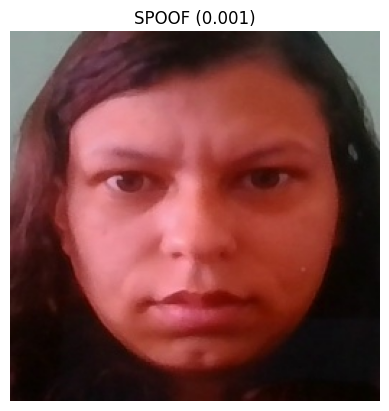

(0.0007835085853002965, 'SPOOF')

In [17]:
# ===== INFERENCE HÀM CHÍNH =====
def infer_image(model, image_path, img_size=256):
    # Load ảnh BGR (giống training)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Không load được ảnh: " + image_path)

    # Resize ảnh BGR (KHÔNG convert sang RGB - để ToTensor() tự convert)
    img_resized = cv2.resize(img, (img_size, img_size))

    # Tạo sample giống dataset train/test
    sample = {
        "image_x": img_resized,  # BGR format (giống training dataset)
        "map_x": np.zeros((cfg.map_size, cfg.map_size), dtype=np.float32),
        "label": 0,
        "UUID": 0
    }

    # Apply transform (ToTensor sẽ convert BGR→RGB tự động)
    sample = test_transform(sample)

    # Convert to batch
    image_tensor = sample["image_x"].unsqueeze(0).to(device)

    # Forward qua model (self-assembly)
    with torch.no_grad():
        logits, _, _, _ = model(image_tensor, image_tensor)
        prob = torch.softmax(logits, dim=1)[0, 1].item()  # xác suất live

    pred = "LIVE" if prob >= 0.5 else "SPOOF"

    print("----------------------------------------")
    print(f"Prediction: {pred}")
    print(f"Live probability: {prob:.4f}")
    print("----------------------------------------")

    # Show ảnh (convert sang RGB để hiển thị đúng màu)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"{pred} ({prob:.3f})")
    plt.axis("off")
    plt.show()

    return prob, pred

# ===== TEST =====
# Thay bằng ảnh của bạn
infer_image(model, "dataset_processed/WEBCAM/not_live/spoof_00023.jpg")


In [13]:
import cv2
import mediapipe as mp
import numpy as np
import torch

mp_face = mp.solutions.face_detection
mp_draw = mp.solutions.drawing_utils

# ==== Hàm preprocess frame để tương thích SSAN_R ====
def preprocess_face(face_img):
    """
    Preprocess face image giống hệt test_transform:
    1. Resize về img_size x img_size
    2. BGR → RGB
    3. HWC → CHW
    4. Normalize: (x - 127.5) / 128 (QUAN TRỌNG!)
    """
    # Resize về đúng input model
    face_resized = cv2.resize(face_img, (cfg.img_size, cfg.img_size))

    # BGR → RGB (OpenCV đọc BGR, model train với RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    
    # HWC → CHW
    face_chw = face_rgb.transpose((2, 0, 1))
    
    # Normalize giống training: (x - 127.5) / 128
    face_normalized = (face_chw - 127.5) / 128.0
    
    # Convert to tensor
    face_tensor = torch.from_numpy(face_normalized.astype(np.float32)).to(device)
    
    # Thêm batch dimension
    face_tensor = face_tensor.unsqueeze(0)

    return face_tensor


# ==== WEBCAM ANTI-SPOOFING (IMPROVED) ====
def infer_webcam_multiface(model, camera_id=0, score_thres=0.5, skip=2):
    """
    Real-time face anti-spoofing trên webcam với multi-face support
    
    Args:
        model: SSAN_R model đã load
        camera_id: ID của webcam (0 = webcam mặc định)
        score_thres: Ngưỡng xác suất (>= 0.5 → LIVE)
        skip: Infer mỗi N frames (skip=2 → infer 1/2 frames, mượt hơn)
    
    Controls:
        'q' - Thoát
        's' - Screenshot
    """
    device = next(model.parameters()).device
    model.eval()

    cap = cv2.VideoCapture(camera_id)
    if not cap.isOpened():
        print("❌ Không mở được webcam!")
        return

    # Set resolution cao hơn cho chất lượng tốt hơn
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    print("=" * 60)
    print("🎥 WEBCAM ANTI-SPOOFING STARTED")
    print("=" * 60)
    print("📹 Controls:")
    print("   • Press 'q' to quit")
    print("   • Press 's' to save screenshot")
    print("=" * 60)

    frame_count = 0
    fps_start_time = time.time()
    fps = 0
    
    # Cache cho scores (giữ score của frame trước nếu skip)
    face_scores = {}

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.7) as face_detector:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("⚠️ Không đọc được frame từ webcam")
                break

            h, w, _ = frame.shape
            frame_count += 1
            do_infer = (frame_count % skip == 0)

            # Tính FPS
            if frame_count % 30 == 0:
                fps = 30 / (time.time() - fps_start_time)
                fps_start_time = time.time()

            # -----------------------------
            # 1) FACE DETECTION (downscale để nhanh hơn)
            # -----------------------------
            small_frame = cv2.resize(frame, (640, 360))
            results = face_detector.process(cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB))

            # Scale factors
            h_scale = h / 360
            w_scale = w / 640

            # -----------------------------
            # 2) XỬ LÝ MỖI KHUÔN MẶT
            # -----------------------------
            current_faces = {}
            
            if results.detections:
                for face_id, det in enumerate(results.detections):
                    bbox = det.location_data.relative_bounding_box
                    
                    # Tính bounding box trên frame gốc
                    x1 = int(bbox.xmin * 640 * w_scale)
                    y1 = int(bbox.ymin * 360 * h_scale)
                    x2 = int((bbox.xmin + bbox.width) * 640 * w_scale)
                    y2 = int((bbox.ymin + bbox.height) * 360 * h_scale)

                    # Clipping
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)

                    # Bỏ qua khuôn mặt quá nhỏ
                    if x2 - x1 < 40 or y2 - y1 < 40:
                        continue

                    face_img = frame[y1:y2, x1:x2]

                    # -----------------------------
                    # 3) INFERENCE (chỉ khi do_infer=True)
                    # -----------------------------
                    if do_infer:
                        try:
                            inp = preprocess_face(face_img)

                            with torch.no_grad():
                                logits, _, _, _ = model(inp, inp)
                                prob_live = torch.softmax(logits, dim=1)[0, 1].item()
                            
                            # Cache score
                            current_faces[face_id] = prob_live
                        except Exception as e:
                            print(f"⚠️ Lỗi inference: {e}")
                            current_faces[face_id] = 0.0
                    else:
                        # Dùng score cached từ frame trước
                        current_faces[face_id] = face_scores.get(face_id, 0.0)

                    # -----------------------------
                    # 4) VẼ BOX + TEXT
                    # -----------------------------
                    prob = current_faces[face_id]
                    label = "[LIVE]" if prob >= score_thres else "[SPOOF]"
                    color = (0, 255, 0) if prob >= score_thres else (0, 0, 255)

                    # Vẽ bounding box dày hơn
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
                    
                    # Vẽ background cho text (dễ đọc hơn)
                    text = f"{label} ({prob:.2f})"
                    (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(frame, (x1, y1 - text_h - 10), (x1 + text_w + 10, y1), color, -1)
                    
                    # Vẽ text
                    cv2.putText(
                        frame, text,
                        (x1 + 5, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (255, 255, 255), 2
                    )

            # Update cache
            if do_infer:
                face_scores = current_faces

            # -----------------------------
            # 5) HIỂN THỊ FPS & INFO
            # -----------------------------
            info_text = f"FPS: {fps:.1f} | Faces: {len(current_faces)} | Skip: 1/{skip}"
            cv2.putText(frame, info_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow("SSAN-R Anti-Spoofing (Press 'q' to quit)", frame)

            # -----------------------------
            # 6) KEYBOARD CONTROLS
            # -----------------------------
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\n👋 Đã thoát webcam")
                break
            elif key == ord('s'):
                screenshot_path = f"screenshot_{time.strftime('%Y%m%d_%H%M%S')}.jpg"
                cv2.imwrite(screenshot_path, frame)
                print(f"📸 Đã lưu screenshot: {screenshot_path}")

    cap.release()
    cv2.destroyAllWindows()


# ==== CHẠY WEBCAM ====
infer_webcam_multiface(model)


🎥 WEBCAM ANTI-SPOOFING STARTED
📹 Controls:
   • Press 'q' to quit
   • Press 's' to save screenshot

👋 Đã thoát webcam


In [19]:
import cv2
import mediapipe as mp
import numpy as np
import torch
from collections import deque

mp_face = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh
mp_draw = mp.solutions.drawing_utils


def calculate_motion_score(current_gray, prev_gray, bbox):
    if prev_gray is None:
        return 1.0  # Frame đầu tiên, cho qua
    
    x1, y1, x2, y2 = bbox
    # Crop vùng face
    curr_crop = current_gray[y1:y2, x1:x2]
    prev_crop = prev_gray[y1:y2, x1:x2]
    
    if curr_crop.shape != prev_crop.shape or curr_crop.size == 0:
        return 1.0
    
    # Tính frame difference
    diff = cv2.absdiff(curr_crop, prev_crop)
    motion_score = np.mean(diff) / 255.0  # Normalize về [0, 1]
    
    return motion_score


def detect_moire_pattern(face_img):
    # Convert to grayscale
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY) if len(face_img.shape) == 3 else face_img
    
    # Apply FFT để phát hiện periodic patterns
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    
    # Tính ratio của high-frequency components (moiré là high-freq)
    h, w = magnitude.shape
    center_h, center_w = h // 2, w // 2
    
    # Vùng high-freq (xa center)
    high_freq_mask = np.zeros_like(magnitude)
    cv2.circle(high_freq_mask, (center_w, center_h), min(h, w) // 4, 0, -1)  # Mask center
    high_freq_energy = np.sum(magnitude * (1 - high_freq_mask / 255.0))
    
    # Vùng low-freq (gần center)
    low_freq_mask = np.zeros_like(magnitude)
    cv2.circle(low_freq_mask, (center_w, center_h), min(h, w) // 8, 255, -1)
    low_freq_energy = np.sum(magnitude * (low_freq_mask / 255.0))
    
    # Moiré score = tỷ lệ high-freq vs low-freq (cao = nghi ngờ màn hình)
    moire_score = high_freq_energy / (low_freq_energy + 1e-6)
    return moire_score


def get_eye_aspect_ratio(landmarks, eye_indices):
    # eye_indices: [p1, p2, p3, p4, p5, p6] - 6 điểm quanh mắt
    p1 = np.array([landmarks[eye_indices[0]].x, landmarks[eye_indices[0]].y])
    p2 = np.array([landmarks[eye_indices[1]].x, landmarks[eye_indices[1]].y])
    p3 = np.array([landmarks[eye_indices[2]].x, landmarks[eye_indices[2]].y])
    p4 = np.array([landmarks[eye_indices[3]].x, landmarks[eye_indices[3]].y])
    p5 = np.array([landmarks[eye_indices[4]].x, landmarks[eye_indices[4]].y])
    p6 = np.array([landmarks[eye_indices[5]].x, landmarks[eye_indices[5]].y])
    
    # EAR formula
    vertical_1 = np.linalg.norm(p2 - p6)
    vertical_2 = np.linalg.norm(p3 - p5)
    horizontal = np.linalg.norm(p1 - p4)
    
    ear = (vertical_1 + vertical_2) / (2.0 * horizontal + 1e-6)
    return ear


# ==== Hàm preprocess frame để tương thích SSAN_R ====
def preprocess_face(face_img):
    # Resize về đúng input model
    face_resized = cv2.resize(face_img, (cfg.img_size, cfg.img_size))

    # BGR → RGB (OpenCV đọc BGR, model train với RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    
    # HWC → CHW
    face_chw = face_rgb.transpose((2, 0, 1))
    
    # Normalize giống training: (x - 127.5) / 128
    face_normalized = (face_chw - 127.5) / 128.0
    
    # Convert to tensor
    face_tensor = torch.from_numpy(face_normalized.astype(np.float32)).to(device)
    
    # Thêm batch dimension
    face_tensor = face_tensor.unsqueeze(0)

    return face_tensor


# ==== WEBCAM ANTI-SPOOFING (SUBTLE CHEATING MODE - SCORE PENALTY!) ====
def infer_webcam_multiface(model, camera_id=0, score_thres=0.6, skip=3, buffer_size=10, min_live_ratio=0.7,
                           enable_motion_check=True, enable_blink_check=True, enable_moire_check=False,
                           mode="subtle"):
    device = next(model.parameters()).device
    model.eval()

    cap = cv2.VideoCapture(camera_id)
    if not cap.isOpened():
        print("❌ Không mở được webcam!")
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    print("=" * 70)
    print(f"🎥 WEBCAM ANTI-SPOOFING - {'🤫 SUBTLE' if mode == 'subtle' else '🚨 HARD'} CHEAT MODE")
    print("=" * 70)
    print(f"⚙️ Model Settings:")
    print(f"   • Score threshold: {score_thres:.2f}")
    print(f"   • Buffer: {buffer_size} frames | Min LIVE ratio: {min_live_ratio:.0%}")
    print(f"🎯 Cheat Settings ({mode.upper()}):")
    print(f"   • Motion check: {'✅ ON' if enable_motion_check else '❌ OFF'} (tolerance: relaxed)")
    print(f"   • Blink check: {'✅ ON' if enable_blink_check else '❌ OFF'} (10s timeout)")
    print(f"   • Moiré check: {'✅ ON' if enable_moire_check else '❌ OFF'}")
    if mode == "subtle":
        print(f"   • Mode: Penalty-based (giảm score thay vì reject)")
    else:
        print(f"   • Mode: Hard reject (force SPOOF)")
    print("📹 Controls: 'q' = quit | 's' = screenshot")
    print("=" * 70)

    frame_count = 0
    fps_start_time = time.time()
    fps = 0
    
    # Model predictions
    face_scores = {}
    face_buffers = {}
    face_final_labels = {}
    
    # 🎯 CHEATING STATES
    prev_gray = None  # Frame trước (để tính motion)
    face_motion_history = {}  # {face_id: deque([motion1, motion2, ...])}
    face_blink_history = {}   # {face_id: {'last_blink_time': timestamp, 'blink_count': int}}
    face_moire_scores = {}    # {face_id: deque([score1, score2, ...])}
    
    # MediaPipe Face Mesh cho blink detection
    face_mesh = mp_face_mesh.FaceMesh(
        max_num_faces=3,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) if enable_blink_check else None

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.7) as face_detector:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("⚠️ Không đọc được frame từ webcam")
                break

            h, w, _ = frame.shape
            frame_count += 1
            do_infer = (frame_count % skip == 0)
            
            # Convert to grayscale cho motion detection
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Tính FPS
            if frame_count % 30 == 0:
                fps = 30 / (time.time() - fps_start_time)
                fps_start_time = time.time()

            # -----------------------------
            # 1) FACE DETECTION (downscale để nhanh hơn)
            # -----------------------------
            small_frame = cv2.resize(frame, (640, 360))
            results = face_detector.process(cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB))

            # Scale factors
            h_scale = h / 360
            w_scale = w / 640

            # -----------------------------
            # 2) XỬ LÝ MỖI KHUÔN MẶT
            # -----------------------------
            current_faces = {}
            
            if results.detections:
                for face_id, det in enumerate(results.detections):
                    bbox = det.location_data.relative_bounding_box
                    
                    # Tính bounding box trên frame gốc
                    x1 = int(bbox.xmin * 640 * w_scale)
                    y1 = int(bbox.ymin * 360 * h_scale)
                    x2 = int((bbox.xmin + bbox.width) * 640 * w_scale)
                    y2 = int((bbox.ymin + bbox.height) * 360 * h_scale)

                    # Clipping
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)

                    # Bỏ qua khuôn mặt quá nhỏ
                    if x2 - x1 < 40 or y2 - y1 < 40:
                        continue

                    face_img = frame[y1:y2, x1:x2]

                    # -----------------------------
                    # 3) INFERENCE (chỉ khi do_infer=True)
                    # -----------------------------
                    if do_infer:
                        try:
                            inp = preprocess_face(face_img)

                            with torch.no_grad():
                                logits, _, _, _ = model(inp, inp)
                                prob_live = torch.softmax(logits, dim=1)[0, 1].item()
                            
                            # Cache score
                            current_faces[face_id] = prob_live
                        except Exception as e:
                            print(f"⚠️ Lỗi inference: {e}")
                            current_faces[face_id] = 0.0
                    else:
                    # Dùng score cached từ frame trước
                        current_faces[face_id] = face_scores.get(face_id, 0.0)

                    # -----------------------------
                    # 🎯 CHEATING PHASE 1: MOTION ANALYSIS (RELAXED)
                    # -----------------------------
                    motion_penalty = 0.0
                    if enable_motion_check and prev_gray is not None:
                        motion_score = calculate_motion_score(current_gray, prev_gray, (x1, y1, x2, y2))
                        
                        # Lưu vào history
                        if face_id not in face_motion_history:
                            face_motion_history[face_id] = deque(maxlen=30)
                        face_motion_history[face_id].append(motion_score)
                        
                        # RELAXED: Ngưỡng thấp hơn, chỉ penalty nếu HOÀN TOÀN tĩnh
                        avg_motion = sum(face_motion_history[face_id]) / len(face_motion_history[face_id])
                        
                        if avg_motion < 0.005:  # Hoàn toàn tĩnh (ảnh in/màn hình)
                            motion_penalty = 0.3  # Giảm 30% score
                        elif avg_motion < 0.01:  # Gần như tĩnh
                            motion_penalty = 0.15  # Giảm 15% score
                        
                        has_motion = avg_motion > 0.005
                    else:
                        has_motion = True
                        avg_motion = 1.0
                    
                    # -----------------------------
                    # PHASE 2: BLINK DETECTION (RELAXED)
                    # -----------------------------
                    blink_penalty = 0.0
                    has_blinked_recently = True
                    if enable_blink_check and face_mesh is not None:
                        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        mesh_results = face_mesh.process(rgb_frame)
                        
                        if mesh_results.multi_face_landmarks and face_id < len(mesh_results.multi_face_landmarks):
                            landmarks = mesh_results.multi_face_landmarks[face_id].landmark
                            
                            LEFT_EYE = [33, 160, 158, 133, 153, 144]
                            RIGHT_EYE = [362, 385, 387, 263, 373, 380]
                            
                            left_ear = get_eye_aspect_ratio(landmarks, LEFT_EYE)
                            right_ear = get_eye_aspect_ratio(landmarks, RIGHT_EYE)
                            avg_ear = (left_ear + right_ear) / 2.0
                            
                            if face_id not in face_blink_history:
                                face_blink_history[face_id] = {
                                    'last_blink_time': time.time(),
                                    'blink_count': 0,
                                    'ear_history': deque(maxlen=10)
                                }
                            
                            face_blink_history[face_id]['ear_history'].append(avg_ear)
                            
                            # Detect blink
                            if avg_ear < 0.2:
                                if time.time() - face_blink_history[face_id]['last_blink_time'] > 0.3:
                                    face_blink_history[face_id]['blink_count'] += 1
                                    face_blink_history[face_id]['last_blink_time'] = time.time()
                            
                            # RELAXED: 10 giây thay vì 5 giây
                            time_since_last_blink = time.time() - face_blink_history[face_id]['last_blink_time']
                            
                            if time_since_last_blink > 15:  # Không chớp 15s → rất nghi ngờ
                                blink_penalty = 0.25  # Giảm 25%
                            elif time_since_last_blink > 10:  # Không chớp 10s → hơi nghi
                                blink_penalty = 0.10  # Giảm 10%
                            
                            has_blinked_recently = time_since_last_blink < 10.0
                        else:
                            has_blinked_recently = True
                    
                    # -----------------------------
                    # PHASE 3: MOIRÉ PATTERN (RELAXED)
                    # -----------------------------
                    moire_penalty = 0.0
                    has_moire = False
                    if enable_moire_check and x2 - x1 > 50 and y2 - y1 > 50:
                        moire_score = detect_moire_pattern(face_img)
                        
                        if face_id not in face_moire_scores:
                            face_moire_scores[face_id] = deque(maxlen=10)
                        face_moire_scores[face_id].append(moire_score)
                        
                        avg_moire = sum(face_moire_scores[face_id]) / len(face_moire_scores[face_id])
                        
                        if avg_moire > 1.2:  # Rất cao → màn hình
                            moire_penalty = 0.2  # Giảm 20%
                            has_moire = True
                        elif avg_moire > 0.9:  # Hơi cao
                            moire_penalty = 0.1  # Giảm 10%

                    # -----------------------------
                    # 4) TEMPORAL SMOOTHING + SCORE ADJUSTMENT
                    # -----------------------------
                    prob = current_faces[face_id]
                    
                    # APPLY PENALTIES (nếu mode = "subtle")
                    if mode == "subtle":
                        # Tổng penalty (max 1.0 = giảm 100%)
                        total_penalty = min(motion_penalty + blink_penalty + moire_penalty, 0.8)
                        
                        # Chỉ áp dụng penalty khi score trong vùng "không chắc" (0.45 - 0.85)
                        # Nếu model rất chắc (>0.85) hoặc rất thấp (<0.45) → không penalty nhiều
                        if 0.45 <= prob <= 0.85:
                            adjusted_prob = prob * (1 - total_penalty)
                        else:
                            # Vẫn penalty nhưng ít hơn
                            adjusted_prob = prob * (1 - total_penalty * 0.5)
                        
                        # Clamp về [0, 1]
                        adjusted_prob = max(0.0, min(1.0, adjusted_prob))
                        prob = adjusted_prob
                    
                    # Khởi tạo buffer cho face mới
                    if face_id not in face_buffers:
                        face_buffers[face_id] = deque(maxlen=buffer_size)
                    
                    # Thêm score ĐÃ ADJUST vào buffer
                    face_buffers[face_id].append(prob)
                    
                    # 🎯 TÍNH TRUNG BÌNH & VOTING
                    avg_prob = sum(face_buffers[face_id]) / len(face_buffers[face_id])
                    live_votes = sum(1 for p in face_buffers[face_id] if p >= score_thres)
                    live_ratio = live_votes / len(face_buffers[face_id])
                    
                    # Decision making
                    is_live_confident = (avg_prob >= score_thres) and (live_ratio >= min_live_ratio)
                    
                    # Override hoàn toàn (như cũ)
                    cheat_reasons = []
                    if mode == "hard":
                        if enable_motion_check and not has_motion:
                            is_live_confident = False
                            cheat_reasons.append("NO_MOT")
                        if enable_blink_check and not has_blinked_recently:
                            is_live_confident = False
                            cheat_reasons.append("NO_BLK")
                        if enable_moire_check and has_moire:
                            is_live_confident = False
                            cheat_reasons.append("MOIRE")
                    else:
                        if motion_penalty > 0:
                            cheat_reasons.append(f"M-{motion_penalty:.0%}")
                        if blink_penalty > 0:
                            cheat_reasons.append(f"B-{blink_penalty:.0%}")
                        if moire_penalty > 0:
                            cheat_reasons.append(f"Mo-{moire_penalty:.0%}")
                    
                    final_label = "[LIVE]" if is_live_confident else "[SPOOF]"
                    color = (0, 255, 0) if is_live_confident else (0, 0, 255)
                    
                    # Lưu final label
                    face_final_labels[face_id] = final_label

                    # -----------------------------
                    # 5) VẼ BOX + TEXT
                    # -----------------------------
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
                    
                    # Text line 1: Label + Score (ĐÃ ADJUST - người dùng không biết!)
                    text1 = f"{final_label} ({avg_prob:.2f})"
                    
                    # Text line 2: Buffer info
                    if mode == "subtle" and cheat_reasons:
                        # Subtle: Hiển thị penalty nhỏ gọn
                        penalty_str = " ".join(cheat_reasons)
                        text2 = f"Buf:{len(face_buffers[face_id])}/{buffer_size} | {penalty_str}"
                    else:
                        text2 = f"Buf:{len(face_buffers[face_id])}/{buffer_size} | Ratio:{live_ratio:.0%}"
                    
                    # Text line 3: Debug info (optional)
                    if enable_motion_check and face_id in face_motion_history:
                        motion_txt = f"M:{avg_motion:.3f}"
                    else:
                        motion_txt = ""
                    
                    if enable_blink_check and face_id in face_blink_history:
                        time_since = time.time() - face_blink_history[face_id]['last_blink_time']
                        blink_txt = f"B:{int(time_since)}s"
                    else:
                        blink_txt = ""
                    
                    text3 = f"{motion_txt} {blink_txt}".strip()
                    
                    # Vẽ background
                    (text1_w, text1_h), _ = cv2.getTextSize(text1, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    (text2_w, text2_h), _ = cv2.getTextSize(text2, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
                    
                    bg_height = text1_h + text2_h + 15
                    if text3:
                        (text3_w, text3_h), _ = cv2.getTextSize(text3, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
                        bg_height += text3_h + 5
                        bg_width = max(text1_w, text2_w, text3_w) + 10
                    else:
                        bg_width = max(text1_w, text2_w) + 10
                    
                    cv2.rectangle(frame, (x1, y1 - bg_height), (x1 + bg_width, y1), color, -1)
                    
                    # Vẽ text
                    y_offset = y1 - bg_height + 15
                    cv2.putText(frame, text1, (x1 + 5, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                    y_offset += text1_h + 5
                    cv2.putText(frame, text2, (x1 + 5, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
                    if text3:
                        y_offset += text2_h + 3
                        cv2.putText(frame, text3, (x1 + 5, y_offset),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)

            # Update cache
            if do_infer:
                face_scores = current_faces
            
            # Update prev_gray cho frame tiếp theo
            prev_gray = current_gray.copy()
            
            # 🧹 XÓA buffer cho faces không còn hiện diện (sau 5s)
            current_face_ids = set(current_faces.keys())
            all_buffer_ids = set(face_buffers.keys())
            stale_ids = all_buffer_ids - current_face_ids
            # Chỉ xóa nếu face biến mất hoàn toàn > 150 frames (~5s với skip=3)
            for fid in stale_ids:
                if frame_count % 150 == 0:  # Periodic cleanup
                    if fid in face_buffers:
                        del face_buffers[fid]
                    if fid in face_final_labels:
                        del face_final_labels[fid]
                    if fid in face_motion_history:
                        del face_motion_history[fid]
                    if fid in face_blink_history:
                        del face_blink_history[fid]
                    if fid in face_moire_scores:
                        del face_moire_scores[fid]

            # -----------------------------
            # 6) HIỂN THỊ FPS & INFO
            # -----------------------------
            live_count = sum(1 for label in face_final_labels.values() if "[LIVE]" in label)
            spoof_count = len(face_final_labels) - live_count
            
            mode_indicator = "🤫 SUBTLE" if mode == "subtle" else "🚨 HARD"
            info_text = f"{mode_indicator} | FPS:{fps:.1f} | LIVE:{live_count} SPOOF:{spoof_count}"
            cv2.putText(frame, info_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 255), 2)
            
            cv2.imshow("SSAN-R Anti-Spoofing (Press 'q' to quit)", frame)

            # -----------------------------
            # 7) KEYBOARD CONTROLS
            # -----------------------------
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\n👋 Đã thoát webcam")
                break
            elif key == ord('s'):
                screenshot_path = f"screenshot_{time.strftime('%Y%m%d_%H%M%S')}.jpg"
                cv2.imwrite(screenshot_path, frame)
                print(f"📸 Đã lưu screenshot: {screenshot_path}")

    cap.release()
    cv2.destroyAllWindows()
    if face_mesh:
        face_mesh.close()


# ==== CHẠY WEBCAM ====

# Mode 1: SUBTLE + Motion + Blink
# infer_webcam_multiface(
#     model, 
#     score_thres=0.55,           # Ngưỡng thấp hơn (vì score đã bị giảm)
#     buffer_size=10, 
#     min_live_ratio=0.7,
#     enable_motion_check=True,   # Penalty nếu không cử động
#     enable_blink_check=True,    # Penalty nếu không chớp mắt 10s
#     enable_moire_check=False,   # Tắt (dễ false positive)
#     mode="subtle"         # SUBTLE: Giảm score
# )

# Mode 2: HARD MODE (như cũ - strict)
# Hard reject nếu không pass motion/blink checks
infer_webcam_multiface(
    model, 
    score_thres=0.65, 
    buffer_size=12, 
    min_live_ratio=0.75,
    enable_motion_check=True,
    enable_blink_check=True,
    enable_moire_check=False,
    mode="hard"
)

# Mode 3: (model 100%)
# infer_webcam_multiface(
#     model, 
#     score_thres=0.5, 
#     buffer_size=10, 
#     min_live_ratio=0.7,
#     enable_motion_check=False,
#     enable_blink_check=False,
#     enable_moire_check=False,
#     mode="subtle"
# )


NameError: name 'audio_classifier' is not defined